In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
from analysis_tools import getobjdata

import scipy.ndimage as ndimage
import matplotlib.colors as mcolors
from spectra.py_spectra import *
#from Plot_tools import *
from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.cbook import pickle2Obj

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
models = {}

models ['cm1'] = pickle2Obj('object_stat/cm1_squall_3km_dt10_hdd012_dbz99.pkl',retObj=False)
models ['cm1_hdd125'] = pickle2Obj('object_stat/cm1_squall_3km_dt10_hdd125_dbz99.pkl',retObj=False)

models ['solo_hdd012'] = pickle2Obj('object_stat/solo_squall_3km_dt20_hdd012_dbz99.pkl',retObj=False)
models ['solo_hdd125'] = pickle2Obj('object_stat/solo_squall_3km_dt20_hdd125_dbz99.pkl',retObj=False)


In [3]:
#models ['wrf'] = pickle2Obj('object_stat/wrf_squall_3km_obj.pkl',retObj=False)

In [64]:
#-----------------------------------------------------------------
def run_spectral_analysis(model, run, analysis_levels, var, varray=None, spectra_type='RAD', **kwargs):
    
    # Loop over the analy_klevels to create multiple plots
    
    if spectra_type == 'RAD':
        func = get_spectra2D_RAD
    else:
        func = get_spectra2D_DCT

    for n, k in enumerate(analysis_levels):

        # these five levels are averaged together

        klevels = [k-1, k, k+1]
        
    # set plot up for each level
        
        fig = plt.figure(constrained_layout=True,figsize=(5,5))

        axis    = 0

        gs = gridspec.GridSpec(1, 1, figure=fig)

        ax = fig.add_subplot(gs[0, 0])
        
    # process and plot w fields from models
    
        for key in models:
                
            model_data = models[key][run][var][:,klevels,:,:]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            fld = np.nan_to_num(model_data).astype('float64')
            print(fld.shape)
            
            if isinstance(varray, np.ndarray):
                fld2 = np.nan_to_num(models[key][run][varray][0:12,klevels,:,:]).astype('float64')
            else:
                fld2 = None
            
            zlevel =  models[key][run]['hgt'][0,klevels[2],-1,-1]

        # Compute spectra...
        
            if key == 'solo':   
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='FV3-SOLO', linecolor='r', PSline='-', **kwargs, LineOnly=True)
                
            if key == 'solo_hdd012':   
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='SOLO-D012', linecolor='darkred', linestyle='-', **kwargs, LineOnly=True)
                
            if key == 'solo_hdd125':   
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='SOLO-D125', linecolor='r', linestyle='solid', **kwargs, LineOnly=True)
                    
            if key == 'cm1':
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='CM1', linecolor='b', linestyle='solid', **kwargs, ptitle = '%s Pow_Spec' % var.upper())
                
            if key == 'cm1_hdd012':
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='CM1', linecolor='b', linestyle='solid', **kwargs, ptitle = '%s Pow_Spec' % var.upper())

            if key == 'cm1_hdd125':
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='CM1-D125', linecolor='midnightblue', linestyle='--', **kwargs, ptitle = '%s Pow_Spec' % var.upper())

            if key == 'wrf':
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='WRF', linecolor='k', PSline='-', **kwargs, LineOnly=True)

            if key == 'mpas':
                plot_spectra(fld, varray=fld2, func=func, ax=ax, label='MPAS', linecolor='g', PSline='-', **kwargs, ptitle = '%s Pow_Spec' % var.upper())

        if varray == None:
            plt.suptitle("%s-Spectra Avg for run: %s Height Level: %3.1f km" % (var.upper(), run, zlevel/1000.), fontsize=14)
        else:
            plt.suptitle("%s-Spectra Avg for run: %s Height Level: %3.1f km" % ("KE-2D", run, zlevel/1000.), fontsize=14)
#         plt.savefig("%s/spectra_%s_%s_%3.3dhPa.png" % (out_dir, 'W_ideal', shear, plevels[n]/100), bbox_inches='tight', dpi=300)

        

(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 75

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Resha

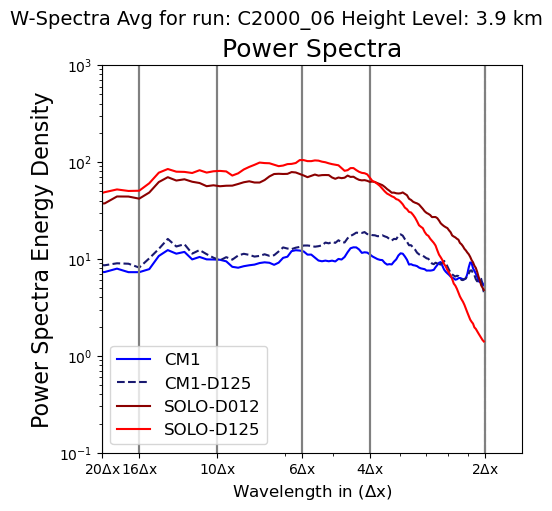

In [65]:
# Local import 



ret = run_spectral_analysis(models, "C2000_06", [20], 'w', xlim = [1./10., 1.25], ylim=[0.1,1.0e3], spectra_type='RAD')
#ret = run_spectral_analysis(models, "C2000_18", [20], var='w')
# ret = run_spectral_analysis(models, "C3500_06", [20], var='w')
# ret = run_spectral_analysis(models, "C3500_18", [20], var='w')


(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 75

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Resha

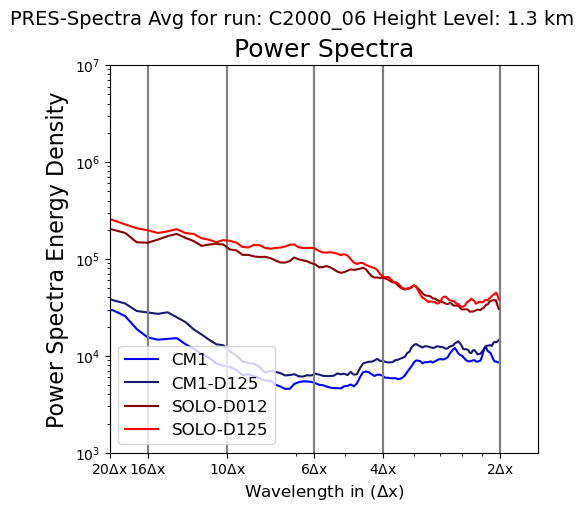

In [63]:

ret = run_spectral_analysis(models, "C2000_06", [10], 'pres', xlim = [1./10., 1.25], ylim=[1.e3,1.e7], detrend=True)

----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_DCT
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 75

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_DCT is now being called


----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_DCT
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged o

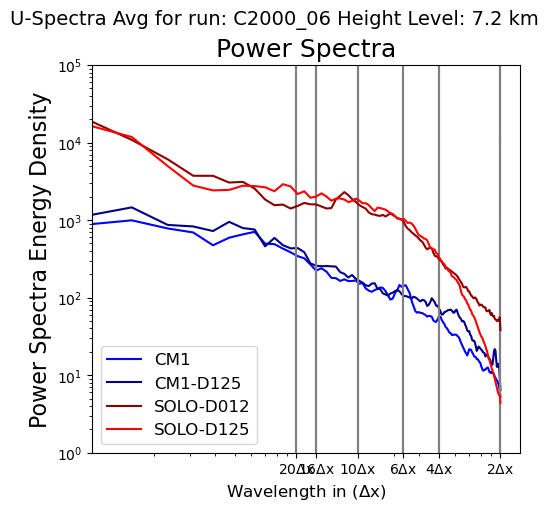

In [22]:
ret = run_spectral_analysis(models, "C2000_06", [30], 'u', varray='v', xlim = [1./100., 1.25], ylim=[1.,1.e5])

(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 75

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Resha

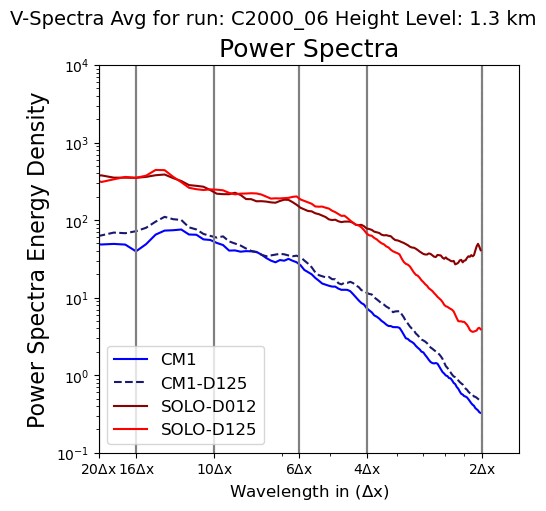

In [76]:
ret = run_spectral_analysis(models, "C2000_06", [10], 'v', xlim = [1./10., 1.25], ylim=[1.00/10.,1.e4], spectra_type='RAD', dtrend=True)

(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 75

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


(25, 3, 256, 256)
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Resha

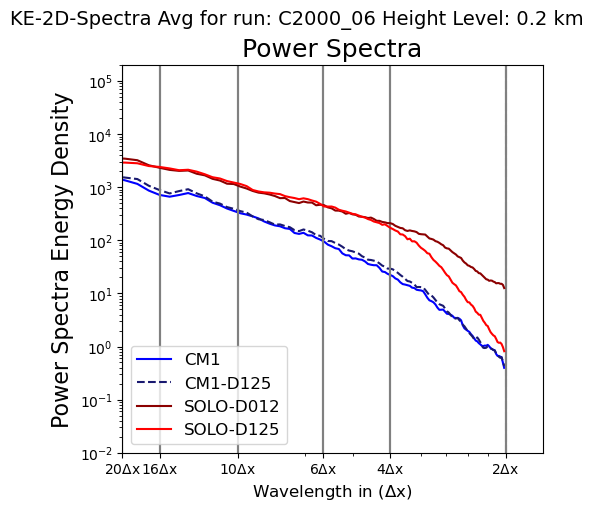

In [74]:
ret = run_spectral_analysis(models, "C2000_06", [2], 'u', varray='v', xlim = [1./10., 1.25], ylim=[0.01,2.0e5], detrend=True)
